# Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

[DBSCAN](https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/) is a density-based clustering algorithm that groups data points that are closely packed together and marks outliers as noise based on their density in the feature space. It  identifies clusters as dense regions in the data space, separated by areas of lower density.

Unlike [K-Means](../1.%20K-Means%20Clustering/k_means_clustering.ipynb), which assumes clusters are compact and spherical, DBSCAN excels in handling real-world data irregularities such as arbitrary-shaped clusters and noise/outliers.

<img src="comparison_table.png" style="width: 45%; display: inline-block;" />
<img src="db_vs_kmeans.jpeg" style="width: 45%; display: inline-block; margin-right: 2%;" />

Due to the similarities between K-means and DBSCAN, we will use the same penguins.csv to compare the two methods. We will also be using the same features: culmen length and body mass/

## Important Parameters
1. **eps (epsilon)** — the neighborhood radius
    - This defines how close points need to be to be considered neighbors. If the distance between two points is less than or equal to eps, they are treated as part of the same neighborhood. Choosing the right eps is crucial:
        - If eps is too small, many points won’t have enough neighbors and will be labeled as noise.

        - If eps is too large, distinct clusters may blend together and become indistinguishable.

    - A common way to find a good eps value is by analyzing the k-distance graph, which plots the distance to each point's k-th nearest neighbor.

2. **MinPts (minimum points)** — the density threshold
    - This sets the minimum number of neighboring points required within the eps radius for a point to be considered a core point. A general rule of thumb is to set MinPts to at least D + 1, where D is the number of dimensions in the dataset. In most cases, a minimum of 3 or more works well.

## Algorithm

<center><img src="dbscan_algorithm.jpeg"/></center>

1. **Identify Core Points:** For each point in the dataset, count the number of points within its eps neighborhood. If the count meets or exceeds MinPts, mark the point as a core point.

2. **Form Clusters:** For each core point that is not already assigned to a cluster, create a new cluster. Recursively find all density-connected points (points within the eps radius of the core point) and add them to the cluster.

3. **Density Connectivity:** Two points, a and b, are density-connected if there exists a chain of points where each point is within the eps radius of the next, and at least one point in the chain is a core point. This chaining process ensures that all points in a cluster are connected through a series of dense regions.

4. **Label Noise Points:** After processing all points, any point that does not belong to a cluster is labeled as noise.

For simplicity, we will import [DBSCAN from scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

## Implement and Evaluate Model

/var/folders/xn/x7k911196hq4qns7w43lghhc0000gn/T/ipykernel_8517/4111131605.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", 35)


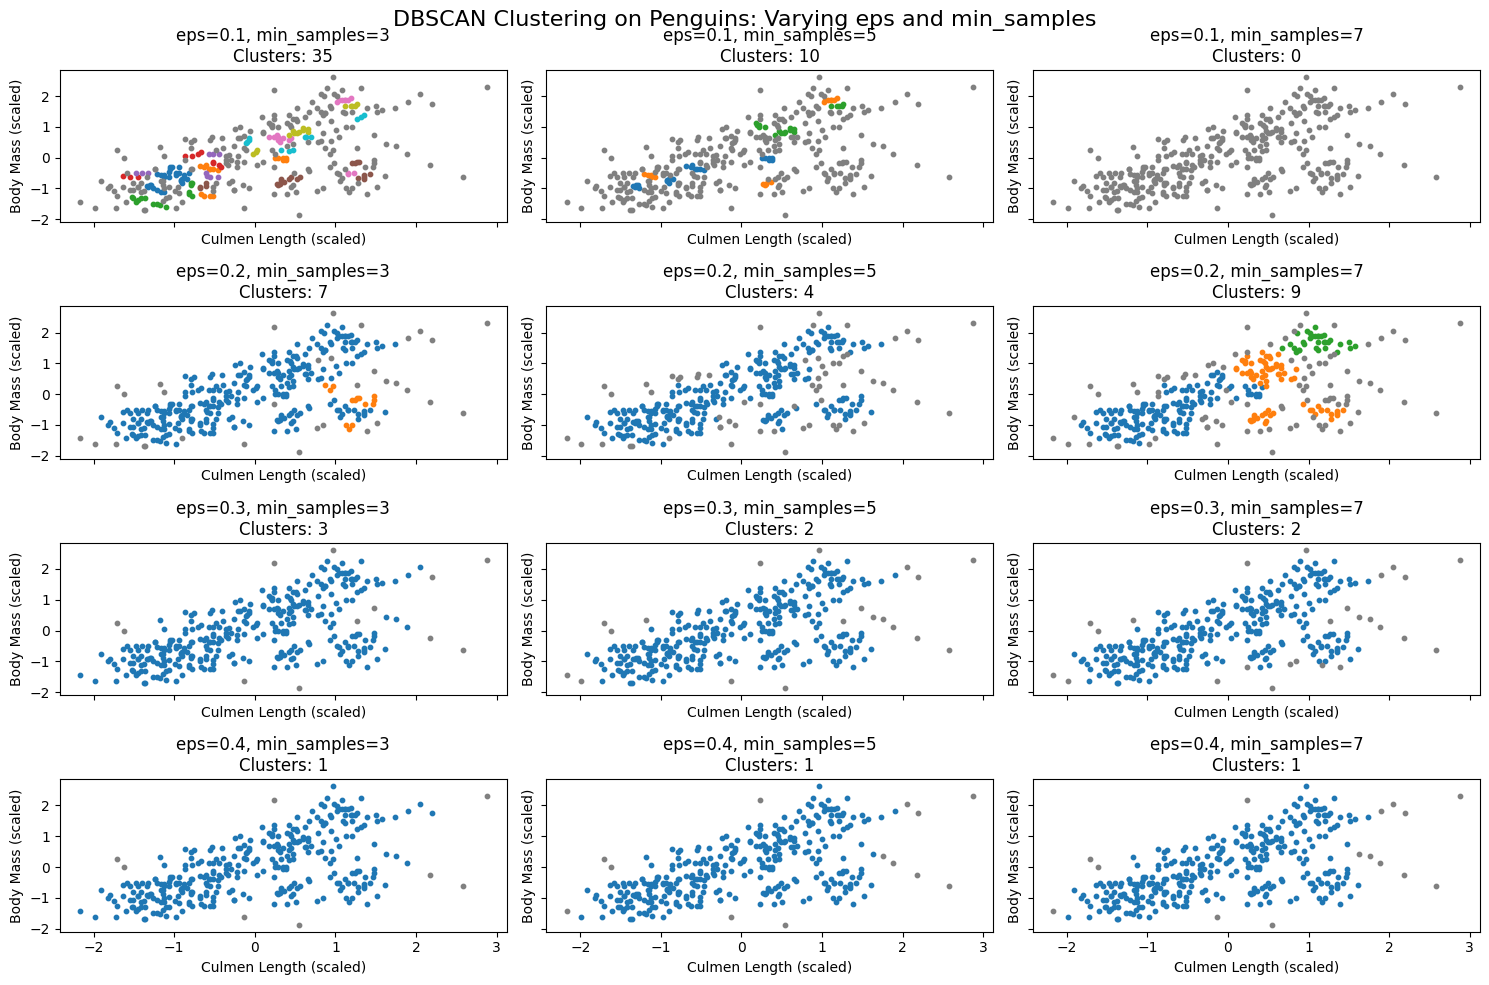

Silhouette Scores by DBSCAN Configuration:
 eps  min_samples  n_clusters  n_noise  silhouette_score
 0.1            3          35      173             0.553
 0.1            5          10      283             0.736
 0.1            7           0      342               NaN
 0.2            3           7       33            -0.178
 0.2            5           4       63             0.031
 0.2            7           9       90             0.215
 0.3            3           3       12             0.106
 0.3            5           2       19             0.213
 0.3            7           2       25             0.201
 0.4            3           1        8               NaN
 0.4            5           1       13               NaN
 0.4            7           1       15               NaN


In [24]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

# Load dataset
df = pd.read_csv("penguins.csv")

# Keep only the relevant numeric columns (culmen_length and body_mass like in k-means)
df_clean = df[["culmen_length_mm", "body_mass_g"]].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)

# Test a range of eps and min_samples values
eps_values = [0.1, 0.2, 0.3, 0.4]
min_samples_values = [3, 5, 7]

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Compute silhouette score (excluding noise)
        if n_clusters > 1:
            mask = labels != -1
            sil_score = silhouette_score(X_scaled[mask], labels[mask])
        else:
            sil_score = None
        
        results.append((eps, min_samples, n_clusters, n_noise, sil_score))

# Create DataFrame
results_df = pd.DataFrame(results, columns=["eps", "min_samples", "n_clusters", "n_noise", "silhouette_score"])

# Plot setup
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle("DBSCAN Clustering on Penguins: Varying eps and min_samples", fontsize=16)

# Color map
cmap = cm.get_cmap("tab10", 35)

# Visualize clusters
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        ax = axes[i, j]
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        for label in unique_labels:
            mask = labels == label

            # Noise points
            if label == -1:
                ax.scatter(X_scaled[mask, 0], X_scaled[mask, 1], 
                           c="gray", label="Noise", s=10)
            else:
                ax.scatter(X_scaled[mask, 0], X_scaled[mask, 1], 
                           color=cmap(label), label=f"Cluster {label}", s=10)

        ax.set_title(f"eps={eps}, min_samples={min_samples}\nClusters: {n_clusters}")
        ax.set_xlabel("Culmen Length (scaled)")
        ax.set_ylabel("Body Mass (scaled)")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Display table
print("Silhouette Scores by DBSCAN Configuration:")
print(results_df.round(3).to_string(index=False))


The DBSCAN clustering results show how sensitive the algorithm is to the choice of eps and min_samples. Visually, smaller eps values (like 0.1) lead to over-segmentation—many small, fragmented clusters and a high number of noise points. As eps increases, the algorithm forms fewer clusters, often merging data into one large group and reducing noise. The highest score (0.736) occurs at eps = 0.1 and min_samples = 5, indicating distinct, well-separated clusters. However, many other configurations yield lower or undefined scores due to too few clusters or all points being labeled as noise. Overall, DBSCAN performs best when carefully tuned; in this dataset, lower eps with moderate min_samples produces the most meaningful clustering.

In contrast, the best silhouette score found in [k_means_clustering.ipynb](../1.%20K-Means%20Clustering/k_means_clustering.ipynb) was 0.48.

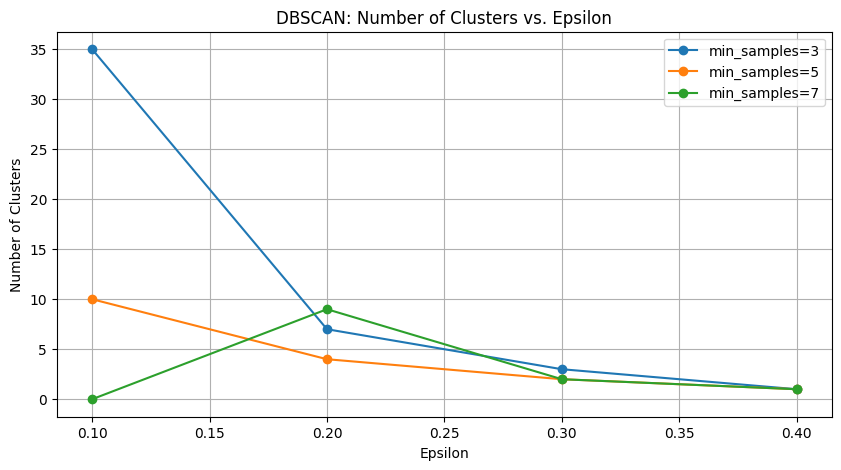

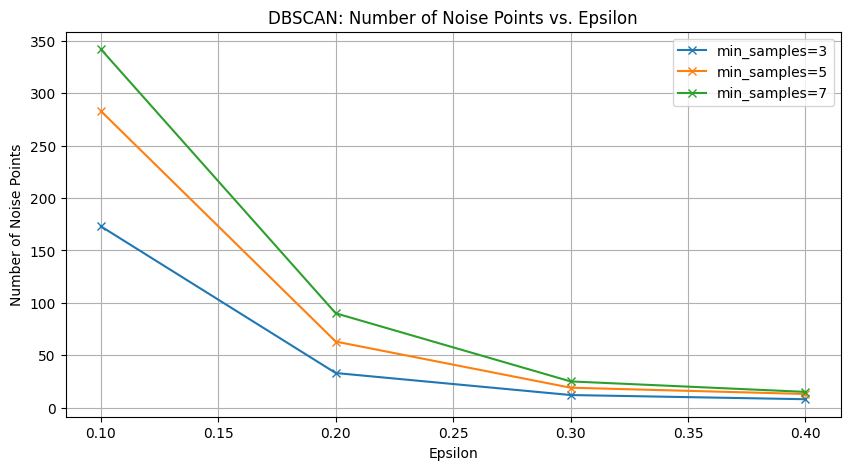

In [21]:
# Visualize results
plt.figure(figsize=(10, 5))
for ms in min_samples_values:
    subset = results_df[results_df["min_samples"] == ms]
    plt.plot(subset["eps"], subset["n_clusters"], marker="o", label=f"min_samples={ms}")

plt.title("DBSCAN: Number of Clusters vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

# Plot noise points
plt.figure(figsize=(10, 5))
for ms in min_samples_values:
    subset = results_df[results_df["min_samples"] == ms]
    plt.plot(subset["eps"], subset["n_noise"], marker="x", label=f"min_samples={ms}")

plt.title("DBSCAN: Number of Noise Points vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Number of Noise Points")
plt.legend()
plt.grid(True)
plt.show()

These two plots highlight how DBSCAN’s clustering behavior varies with the eps and min_samples parameters.

In the first plot, as eps increases, the number of clusters generally decreases for all min_samples values. This is expected: larger eps values merge neighboring clusters into fewer, broader groups. At low eps, especially with min_samples=3, DBSCAN produces many small clusters (e.g., 35 at eps=0.1), which can indicate overfitting.

In the second plot, the number of noise points sharply declines as eps increases. Smaller eps values make it harder for points to meet the density requirement, resulting in more being labeled as noise—especially for higher min_samples. At eps=0.4, noise is minimal across all configurations.

Overall, these plots show that small eps leads to high fragmentation and noise, while larger eps smooths the clustering at the risk of merging distinct groups.

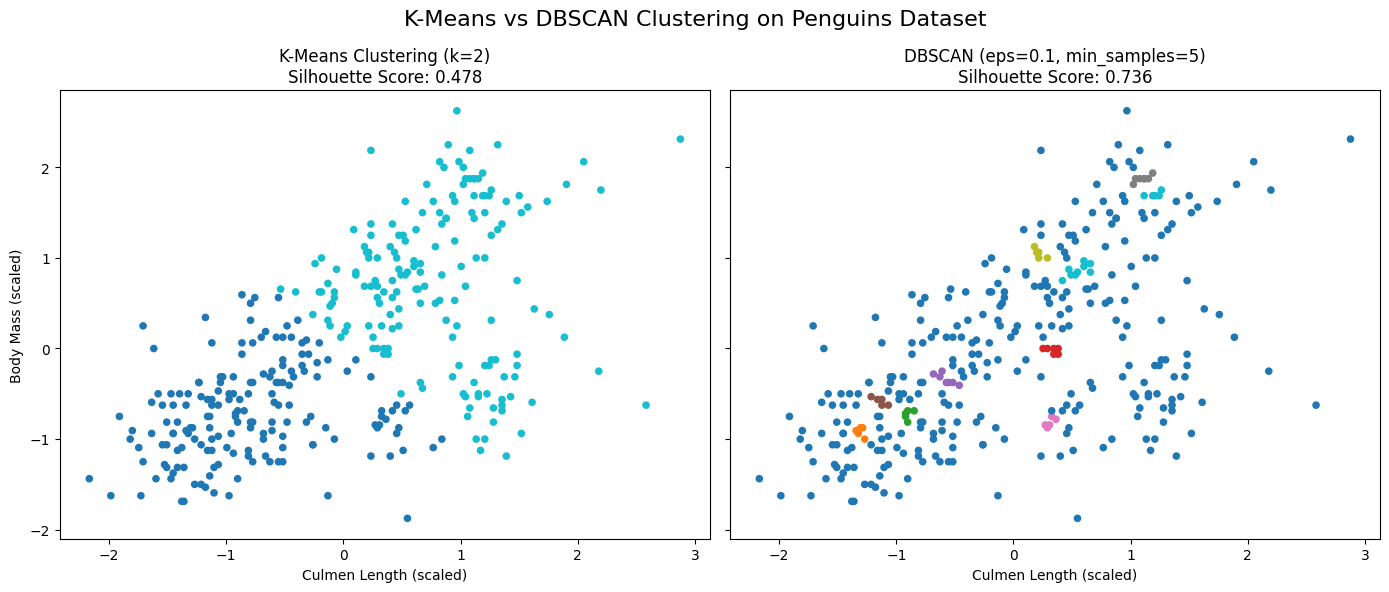

In [27]:
# Apply K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Compute silhouette scores
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)

# For DBSCAN, exclude noise and check for valid cluster count
dbscan_mask = dbscan_labels != -1
if len(set(dbscan_labels[dbscan_mask])) > 1:
    dbscan_sil = silhouette_score(X_scaled[dbscan_mask], dbscan_labels[dbscan_mask])
    dbscan_sil_text = f"{dbscan_sil:.3f}"
else:
    dbscan_sil_text = "N/A"

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# K-Means plot
ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap="tab10", s=20)
ax1.set_title(f"K-Means Clustering (k=2)\nSilhouette Score: {kmeans_sil:.3f}")
ax1.set_xlabel("Culmen Length (scaled)")
ax1.set_ylabel("Body Mass (scaled)")

# DBSCAN plot
ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels, cmap="tab10", s=20)
ax2.set_title(f"DBSCAN (eps=0.1, min_samples=5)\nSilhouette Score: {dbscan_sil_text}")
ax2.set_xlabel("Culmen Length (scaled)")

plt.suptitle("K-Means vs DBSCAN Clustering on Penguins Dataset", fontsize=16)
plt.tight_layout()
plt.show()


This side-by-side comparison highlights the highest silhouette scores achieved by each clustering method. K-Means, with 2 clusters and a silhouette score of 0.478, provides a broader segmentation of the data, capturing the general structure but potentially missing finer groupings. DBSCAN achieves a much higher silhouette score of 0.736, indicating more compact and well-separated clusters—but this comes at the cost of labeling most of the data as noise. The resulting DBSCAN clusters are very small, reflecting a highly fragmented view of the dataset. While both methods optimize for internal cohesion, they differ greatly in how much data they meaningfully cluster.